In [ ]:
import tensorflow as tf
from tensorflow import keras 
import wandb
from wandb.keras import WandbCallback
from PIL import Image
import cv2
import skimage.exposure
import numpy as np
from skimage.restoration import inpaint
from numpy.random import default_rng
import os
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D
from tensorflow.io.gfile import GFile
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/inpainting

/content/drive/MyDrive/Colab Notebooks/inpainting


In [ ]:
class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        mask_ratio = self.window_size / (mask_output + 1e-8)
        mask_output = K.clip(mask_output, 0, 1)
        mask_ratio = mask_ratio * mask_output
        img_output = img_output * mask_ratio

        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [ ]:
latonville_test = np.load('./latonville/test_images.npy')

In [ ]:
river_basin_test = np.load('./river_basin/test_images.npy')

In [ ]:
death_valley_train = np.load('./death_valley/train_images.npy')
death_valley_valid = np.load('./death_valley/validation_images.npy')
death_valley_test = np.load('./death_valley/test_images.npy')

In [ ]:
post_earth_train = np.load('./post_earthquake/train_images.npy')
post_earth_valid = np.load('./post_earthquake/validation_images.npy')
post_earth_test = np.load('./post_earthquake/test_images.npy')

In [ ]:
san_gabriel_train = np.load('./san_gabriel/train_images.npy')
san_gabriel_valid = np.load('./san_gabriel/validation_images.npy')
san_gabriel_test = np.load('./san_gabriel/test_images.npy')

In [ ]:
def resize_images(color_map):
  M = color_map[0].shape[0]//2
  N = color_map[0].shape[1]//2
  list_of_images = []
  for image in range(color_map.shape[0]):
    tiles = [color_map[image][x:x+M,y:y+N] for x in range(0,color_map[0].shape[0],M) for y in range(0,color_map[0].shape[1],N)]
    list_of_images.extend(tiles)
  return np.stack(list_of_images, axis=0)

In [ ]:
color_map_train1 = resize_images(death_valley_train[140:280])
color_map_valid1 = resize_images(death_valley_valid[15:30])
color_map_test1 = resize_images(death_valley_test[15:30])

In [ ]:
color_map_train2 = resize_images(post_earth_train[0:140])
color_map_valid2 = resize_images(post_earth_valid[15:39])
color_map_test2 = resize_images(post_earth_test[0:15])

In [ ]:
color_map_train3 = resize_images(san_gabriel_train[140:280])
color_map_valid3 = resize_images(san_gabriel_valid[0:15])
color_map_test3 = resize_images(san_gabriel_test[15:30])

In [ ]:
color_map_train4 = resize_images(latonville_test[280:350])
color_map_valid4 = resize_images(latonville_test[350:366])
color_map_test4 = resize_images(latonville_test[366:387])

In [ ]:
color_map_train5 = resize_images(river_basin_test[280:350])
color_map_valid5 = resize_images(river_basin_test[350:366])
color_map_test5 = resize_images(river_basin_test[366:387])

In [ ]:
color_map_test = np.concatenate((color_map_test1, color_map_test2, color_map_test3, color_map_test4, color_map_test5), axis=0)

In [ ]:
color_map_valid = np.concatenate((color_map_valid1, color_map_valid2, color_map_valid3, color_map_valid4, color_map_valid5), axis=0)

In [ ]:
color_map_train = np.concatenate((color_map_train4, color_map_train5), axis=0)

In [ ]:
color_map_valid = np.concatenate((color_map_valid1, color_map_valid2, color_map_valid3), axis=0)
color_map_test = np.concatenate((color_map_test1, color_map_test2, color_map_test3), axis=0)

In [ ]:
color_map_train = np.concatenate((color_map_train1, color_map_train2, color_map_train3, color_map_train4, color_map_train5), axis=0)

In [ ]:
np.random.shuffle(color_map_train)
np.random.shuffle(color_map_valid)
np.random.shuffle(color_map_test)

In [ ]:
color_map_train = color_map_train[:,:,:,::-1]
color_map_valid = color_map_valid[:,:,:,::-1]
color_map_test = color_map_test[:,:,:,::-1]

In [ ]:
class createAugment(keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, dim=(32,32), n_channels=3, shuffle=True):
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        return self.__data_generation(indexes)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()
  
            masked_image, mask = self.__createMask(image_copy)      
            Masked_images[i,] = masked_image/255
            Mask_batch[i,] = mask/255
            y_batch[i] = self.y[idx]/255

        return [Masked_images, Mask_batch], y_batch

    def __createMask(self, img):
        noise = np.random.randint(0,256,(256,256), np.uint8)
        blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)
        thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
        mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.merge([mask,mask,mask])
        mask = cv2.bitwise_not(mask)

    ## Mask the image
        masked_image = img.copy()
        masked_image[mask==0] = 255

        return masked_image, mask
            

In [ ]:
traingen = createAugment(color_map_train, color_map_train, 8, (256, 256), shuffle=True)
validgen = createAugment(color_map_valid, color_map_valid, 8, (256, 256), shuffle=True)
testgen = createAugment(color_map_test, color_map_test, 8, (256, 256), shuffle=True)

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [ ]:
def unet_like():
    input_image = keras.layers.Input((256, 256, 3))
    input_mask = keras.layers.Input((256, 256, 3))
    
    conv1 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_image)
    conv1 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(2048, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)
    up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[conv10])  

In [ ]:
class PartialConvolution:
    def prepare_model(self, input_size=(32,32,3)):
        input_image = keras.layers.Input(input_size)
        input_mask = keras.layers.Input(input_size, name='encoder_input')
  
        conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
        conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
        conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
        conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

        conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
        conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
        conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
        conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

        return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
    def __encoder_layer(self, filters, in_layer, in_mask, names):
        conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2

    def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
        up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
        up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
        concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
        concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

        conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2
    


In [ ]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [ ]:
def reset_tensorflow_keras_backend():
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    _ = gc.collect()

In [ ]:
reset_tensorflow_keras_backend()

In [ ]:
run = wandb.init(entity='jedrzej_kopiszka', project="image-impainting_17_12_all_u_net")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
keras.backend.clear_session()
unet_model = unet_like()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=[dice_coef])

In [ ]:
unet_model.fit(traingen, validation_data=validgen, 
          epochs=170, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(validgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/170
  6/351 [..............................] - ETA: 1:17 - loss: 0.1575 - dice_coef: 0.4478

351/351 [==============================] - ETA: 0s - loss: 0.0687 - dice_coef: 0.4774

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.5s


351/351 [==============================] - 222s 585ms/step - loss: 0.0687 - dice_coef: 0.4774 - val_loss: 0.0401 - val_dice_coef: 0.5075
Epoch 2/170
351/351 [==============================] - ETA: 0s - loss: 0.0321 - dice_coef: 0.4926

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 211s 599ms/step - loss: 0.0321 - dice_coef: 0.4926 - val_loss: 0.0282 - val_dice_coef: 0.5135
Epoch 3/170
351/351 [==============================] - 203s 576ms/step - loss: 0.0260 - dice_coef: 0.4952 - val_loss: 0.0285 - val_dice_coef: 0.5222
Epoch 4/170
351/351 [==============================] - ETA: 0s - loss: 0.0227 - dice_coef: 0.4958

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 207s 587ms/step - loss: 0.0227 - dice_coef: 0.4958 - val_loss: 0.0214 - val_dice_coef: 0.5188
Epoch 5/170
351/351 [==============================] - ETA: 0s - loss: 0.0200 - dice_coef: 0.4951

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 208s 590ms/step - loss: 0.0200 - dice_coef: 0.4951 - val_loss: 0.0198 - val_dice_coef: 0.5195
Epoch 6/170
351/351 [==============================] - 203s 577ms/step - loss: 0.0189 - dice_coef: 0.4957 - val_loss: 0.0199 - val_dice_coef: 0.5175
Epoch 7/170
351/351 [==============================] - 201s 572ms/step - loss: 0.0166 - dice_coef: 0.4973 - val_loss: 0.0200 - val_dice_coef: 0.5238
Epoch 8/170
351/351 [==============================] - ETA: 0s - loss: 0.0166 - dice_coef: 0.4968

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 205s 583ms/step - loss: 0.0166 - dice_coef: 0.4968 - val_loss: 0.0159 - val_dice_coef: 0.5231
Epoch 9/170
351/351 [==============================] - 205s 583ms/step - loss: 0.0153 - dice_coef: 0.4973 - val_loss: 0.0221 - val_dice_coef: 0.5106
Epoch 10/170
351/351 [==============================] - ETA: 0s - loss: 0.0143 - dice_coef: 0.4967

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 210s 596ms/step - loss: 0.0143 - dice_coef: 0.4967 - val_loss: 0.0138 - val_dice_coef: 0.5193
Epoch 11/170
351/351 [==============================] - 204s 578ms/step - loss: 0.0142 - dice_coef: 0.4968 - val_loss: 0.0153 - val_dice_coef: 0.5180
Epoch 12/170
351/351 [==============================] - ETA: 0s - loss: 0.0138 - dice_coef: 0.4972

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.3s


351/351 [==============================] - 208s 592ms/step - loss: 0.0138 - dice_coef: 0.4972 - val_loss: 0.0137 - val_dice_coef: 0.5181
Epoch 13/170
351/351 [==============================] - 202s 575ms/step - loss: 0.0133 - dice_coef: 0.4979 - val_loss: 0.0144 - val_dice_coef: 0.5205
Epoch 14/170
351/351 [==============================] - 204s 580ms/step - loss: 0.0130 - dice_coef: 0.4972 - val_loss: 0.0150 - val_dice_coef: 0.5224
Epoch 15/170
351/351 [==============================] - ETA: 0s - loss: 0.0135 - dice_coef: 0.4966

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 208s 592ms/step - loss: 0.0135 - dice_coef: 0.4966 - val_loss: 0.0130 - val_dice_coef: 0.5176
Epoch 16/170
351/351 [==============================] - 199s 565ms/step - loss: 0.0125 - dice_coef: 0.4969 - val_loss: 0.0163 - val_dice_coef: 0.5232
Epoch 17/170
351/351 [==============================] - 200s 568ms/step - loss: 0.0130 - dice_coef: 0.4975 - val_loss: 0.0131 - val_dice_coef: 0.5165
Epoch 18/170
351/351 [==============================] - ETA: 0s - loss: 0.0122 - dice_coef: 0.4974

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 205s 582ms/step - loss: 0.0122 - dice_coef: 0.4974 - val_loss: 0.0120 - val_dice_coef: 0.5212
Epoch 19/170
351/351 [==============================] - ETA: 0s - loss: 0.0124 - dice_coef: 0.4970

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 209s 593ms/step - loss: 0.0124 - dice_coef: 0.4970 - val_loss: 0.0117 - val_dice_coef: 0.5192
Epoch 20/170
351/351 [==============================] - 201s 572ms/step - loss: 0.0127 - dice_coef: 0.4985 - val_loss: 0.0123 - val_dice_coef: 0.5211
Epoch 21/170
351/351 [==============================] - ETA: 0s - loss: 0.0118 - dice_coef: 0.4979

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 206s 585ms/step - loss: 0.0118 - dice_coef: 0.4979 - val_loss: 0.0113 - val_dice_coef: 0.5190
Epoch 22/170
351/351 [==============================] - 204s 581ms/step - loss: 0.0118 - dice_coef: 0.4978 - val_loss: 0.0131 - val_dice_coef: 0.5226
Epoch 23/170
351/351 [==============================] - 203s 576ms/step - loss: 0.0119 - dice_coef: 0.4967 - val_loss: 0.0117 - val_dice_coef: 0.5191
Epoch 24/170
351/351 [==============================] - 208s 592ms/step - loss: 0.0119 - dice_coef: 0.4973 - val_loss: 0.0120 - val_dice_coef: 0.5197
Epoch 25/170
351/351 [==============================] - 202s 574ms/step - loss: 0.0116 - dice_coef: 0.4974 - val_loss: 0.0119 - val_dice_coef: 0.5229
Epoch 26/170
351/351 [==============================] - ETA: 0s - loss: 0.0116 - dice_coef: 0.4978

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 206s 584ms/step - loss: 0.0116 - dice_coef: 0.4978 - val_loss: 0.0111 - val_dice_coef: 0.5209
Epoch 27/170
351/351 [==============================] - 204s 580ms/step - loss: 0.0119 - dice_coef: 0.4977 - val_loss: 0.0118 - val_dice_coef: 0.5183
Epoch 28/170
351/351 [==============================] - 204s 581ms/step - loss: 0.0118 - dice_coef: 0.4979 - val_loss: 0.0136 - val_dice_coef: 0.5156
Epoch 29/170
351/351 [==============================] - ETA: 0s - loss: 0.0118 - dice_coef: 0.4971

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 209s 595ms/step - loss: 0.0118 - dice_coef: 0.4971 - val_loss: 0.0108 - val_dice_coef: 0.5190
Epoch 30/170
351/351 [==============================] - 199s 565ms/step - loss: 0.0114 - dice_coef: 0.4979 - val_loss: 0.0112 - val_dice_coef: 0.5210
Epoch 31/170
351/351 [==============================] - ETA: 0s - loss: 0.0111 - dice_coef: 0.4975

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 205s 582ms/step - loss: 0.0111 - dice_coef: 0.4975 - val_loss: 0.0108 - val_dice_coef: 0.5179
Epoch 32/170
351/351 [==============================] - 202s 574ms/step - loss: 0.0113 - dice_coef: 0.4981 - val_loss: 0.0110 - val_dice_coef: 0.5198
Epoch 33/170
351/351 [==============================] - 199s 567ms/step - loss: 0.0110 - dice_coef: 0.4977 - val_loss: 0.0109 - val_dice_coef: 0.5211
Epoch 34/170
351/351 [==============================] - 199s 564ms/step - loss: 0.0108 - dice_coef: 0.4983 - val_loss: 0.0113 - val_dice_coef: 0.5204
Epoch 35/170
351/351 [==============================] - 200s 569ms/step - loss: 0.0110 - dice_coef: 0.4975 - val_loss: 0.0164 - val_dice_coef: 0.5160
Epoch 36/170
351/351 [==============================] - 203s 576ms/step - loss: 0.0118 - dice_coef: 0.4972 - val_loss: 0.0204 - val_dice_coef: 0.5269
Epoch 37/170
351/351 [==============================] - 199s 567ms/step - loss: 0.0113 - dice_coef: 0.4976 - val_

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.3s


351/351 [==============================] - 204s 580ms/step - loss: 0.0102 - dice_coef: 0.4986 - val_loss: 0.0102 - val_dice_coef: 0.5210
Epoch 44/170
351/351 [==============================] - ETA: 0s - loss: 0.0107 - dice_coef: 0.4975

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 206s 584ms/step - loss: 0.0107 - dice_coef: 0.4975 - val_loss: 0.0098 - val_dice_coef: 0.5209
Epoch 45/170
351/351 [==============================] - 199s 566ms/step - loss: 0.0104 - dice_coef: 0.4980 - val_loss: 0.0117 - val_dice_coef: 0.5220
Epoch 46/170
351/351 [==============================] - 201s 571ms/step - loss: 0.0101 - dice_coef: 0.4970 - val_loss: 0.0110 - val_dice_coef: 0.5210
Epoch 47/170
351/351 [==============================] - ETA: 0s - loss: 0.0107 - dice_coef: 0.4973

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 206s 586ms/step - loss: 0.0107 - dice_coef: 0.4973 - val_loss: 0.0098 - val_dice_coef: 0.5214
Epoch 48/170
351/351 [==============================] - 203s 577ms/step - loss: 0.0102 - dice_coef: 0.4966 - val_loss: 0.0099 - val_dice_coef: 0.5182
Epoch 49/170
351/351 [==============================] - 199s 564ms/step - loss: 0.0100 - dice_coef: 0.4981 - val_loss: 0.0106 - val_dice_coef: 0.5201
Epoch 50/170
351/351 [==============================] - 202s 575ms/step - loss: 0.0107 - dice_coef: 0.4975 - val_loss: 0.0099 - val_dice_coef: 0.5188
Epoch 51/170
351/351 [==============================] - ETA: 0s - loss: 0.0104 - dice_coef: 0.4983

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221217_123243-1ys3idip/files/model-best)... Done. 0.4s


351/351 [==============================] - 205s 583ms/step - loss: 0.0104 - dice_coef: 0.4983 - val_loss: 0.0095 - val_dice_coef: 0.5204
Epoch 52/170
351/351 [==============================] - 203s 576ms/step - loss: 0.0101 - dice_coef: 0.4973 - val_loss: 0.0104 - val_dice_coef: 0.5201
Epoch 53/170
351/351 [==============================] - 203s 577ms/step - loss: 0.0098 - dice_coef: 0.4978 - val_loss: 0.0103 - val_dice_coef: 0.5199
Epoch 54/170
351/351 [==============================] - 204s 580ms/step - loss: 0.0100 - dice_coef: 0.4974 - val_loss: 0.0104 - val_dice_coef: 0.5195
Epoch 55/170
351/351 [==============================] - 203s 577ms/step - loss: 0.0099 - dice_coef: 0.4972 - val_loss: 0.0096 - val_dice_coef: 0.5209
Epoch 56/170
309/351 [=========================>....] - ETA: 20s - loss: 0.0100 - dice_coef: 0.4975

In [ ]:
#run = wandb.init()
artifact = run.use_artifact('jedrzej_kopiszka/uncategorized/model-rosy-darkness-9:v5', type='model')
artifact_dir = artifact.download()
best_model_path = './artifacts/model-rosy-darkness-9:v5'
best_model = keras.models.load_model(best_model_path, custom_objects={"dice_coef":dice_coef})

NameError: ignored

In [ ]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=[dice_coef])
best_model.fit(traingen, validation_data=validgen, 
          epochs=60, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(validgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/60
  6/280 [..............................] - ETA: 59s - loss: 0.0090 - dice_coef: 0.5359 

280/280 [==============================] - ETA: 0s - loss: 0.0086 - dice_coef: 0.5133

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.5s


280/280 [==============================] - 186s 602ms/step - loss: 0.0086 - dice_coef: 0.5133 - val_loss: 0.0087 - val_dice_coef: 0.5201
Epoch 2/60
280/280 [==============================] - 170s 606ms/step - loss: 0.0084 - dice_coef: 0.5138 - val_loss: 0.0088 - val_dice_coef: 0.5183
Epoch 3/60
280/280 [==============================] - ETA: 0s - loss: 0.0083 - dice_coef: 0.5134

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 171s 608ms/step - loss: 0.0083 - dice_coef: 0.5134 - val_loss: 0.0087 - val_dice_coef: 0.5187
Epoch 4/60
280/280 [==============================] - 165s 587ms/step - loss: 0.0083 - dice_coef: 0.5140 - val_loss: 0.0089 - val_dice_coef: 0.5174
Epoch 5/60
280/280 [==============================] - 165s 586ms/step - loss: 0.0085 - dice_coef: 0.5130 - val_loss: 0.0088 - val_dice_coef: 0.5219
Epoch 6/60
280/280 [==============================] - ETA: 0s - loss: 0.0082 - dice_coef: 0.5139

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 167s 596ms/step - loss: 0.0082 - dice_coef: 0.5139 - val_loss: 0.0084 - val_dice_coef: 0.5200
Epoch 7/60
280/280 [==============================] - 166s 591ms/step - loss: 0.0085 - dice_coef: 0.5137 - val_loss: 0.0085 - val_dice_coef: 0.5206
Epoch 8/60
280/280 [==============================] - 164s 584ms/step - loss: 0.0083 - dice_coef: 0.5136 - val_loss: 0.0089 - val_dice_coef: 0.5214
Epoch 9/60
280/280 [==============================] - 166s 593ms/step - loss: 0.0082 - dice_coef: 0.5138 - val_loss: 0.0086 - val_dice_coef: 0.5198
Epoch 10/60
280/280 [==============================] - 166s 591ms/step - loss: 0.0084 - dice_coef: 0.5132 - val_loss: 0.0085 - val_dice_coef: 0.5167
Epoch 11/60
280/280 [==============================] - 165s 586ms/step - loss: 0.0083 - dice_coef: 0.5133 - val_loss: 0.0090 - val_dice_coef: 0.5203
Epoch 12/60
280/280 [==============================] - 164s 583ms/step - loss: 0.0083 - dice_coef: 0.5136 - val_loss: 0.0

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 172s 613ms/step - loss: 0.0083 - dice_coef: 0.5134 - val_loss: 0.0081 - val_dice_coef: 0.5202
Epoch 16/60
280/280 [==============================] - 164s 584ms/step - loss: 0.0083 - dice_coef: 0.5134 - val_loss: 0.0086 - val_dice_coef: 0.5205
Epoch 17/60
280/280 [==============================] - 162s 577ms/step - loss: 0.0081 - dice_coef: 0.5135 - val_loss: 0.0084 - val_dice_coef: 0.5215
Epoch 18/60
280/280 [==============================] - 163s 581ms/step - loss: 0.0081 - dice_coef: 0.5136 - val_loss: 0.0083 - val_dice_coef: 0.5204
Epoch 19/60
280/280 [==============================] - 163s 579ms/step - loss: 0.0083 - dice_coef: 0.5128 - val_loss: 0.0090 - val_dice_coef: 0.5195
Epoch 20/60
280/280 [==============================] - 165s 586ms/step - loss: 0.0082 - dice_coef: 0.5133 - val_loss: 0.0086 - val_dice_coef: 0.5192
Epoch 21/60
280/280 [==============================] - ETA: 0s - loss: 0.0081 - dice_coef: 0.5134

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 170s 606ms/step - loss: 0.0081 - dice_coef: 0.5134 - val_loss: 0.0081 - val_dice_coef: 0.5205
Epoch 22/60
280/280 [==============================] - 162s 575ms/step - loss: 0.0081 - dice_coef: 0.5135 - val_loss: 0.0085 - val_dice_coef: 0.5213
Epoch 23/60
280/280 [==============================] - 165s 588ms/step - loss: 0.0083 - dice_coef: 0.5130 - val_loss: 0.0082 - val_dice_coef: 0.5214
Epoch 24/60
280/280 [==============================] - 164s 583ms/step - loss: 0.0081 - dice_coef: 0.5124 - val_loss: 0.0083 - val_dice_coef: 0.5209
Epoch 25/60
280/280 [==============================] - 163s 579ms/step - loss: 0.0079 - dice_coef: 0.5136 - val_loss: 0.0082 - val_dice_coef: 0.5203
Epoch 26/60
280/280 [==============================] - 163s 581ms/step - loss: 0.0081 - dice_coef: 0.5136 - val_loss: 0.0086 - val_dice_coef: 0.5216
Epoch 27/60
280/280 [==============================] - 164s 586ms/step - loss: 0.0081 - dice_coef: 0.5135 - val_loss: 

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 167s 594ms/step - loss: 0.0081 - dice_coef: 0.5137 - val_loss: 0.0080 - val_dice_coef: 0.5213
Epoch 30/60
280/280 [==============================] - 164s 583ms/step - loss: 0.0080 - dice_coef: 0.5132 - val_loss: 0.0084 - val_dice_coef: 0.5191
Epoch 31/60
280/280 [==============================] - 165s 587ms/step - loss: 0.0081 - dice_coef: 0.5132 - val_loss: 0.0080 - val_dice_coef: 0.5182
Epoch 32/60
280/280 [==============================] - 163s 582ms/step - loss: 0.0080 - dice_coef: 0.5140 - val_loss: 0.0084 - val_dice_coef: 0.5212
Epoch 33/60
280/280 [==============================] - 165s 588ms/step - loss: 0.0081 - dice_coef: 0.5141 - val_loss: 0.0086 - val_dice_coef: 0.5195
Epoch 34/60
280/280 [==============================] - 162s 577ms/step - loss: 0.0081 - dice_coef: 0.5128 - val_loss: 0.0083 - val_dice_coef: 0.5207
Epoch 35/60
280/280 [==============================] - ETA: 0s - loss: 0.0079 - dice_coef: 0.5131

wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/inpainting/wandb/run-20221218_124448-2h4xwfbe/files/model-best)... Done. 0.4s


280/280 [==============================] - 168s 598ms/step - loss: 0.0079 - dice_coef: 0.5131 - val_loss: 0.0078 - val_dice_coef: 0.5208
Epoch 36/60
280/280 [==============================] - 165s 587ms/step - loss: 0.0079 - dice_coef: 0.5133 - val_loss: 0.0081 - val_dice_coef: 0.5196
Epoch 37/60
280/280 [==============================] - 163s 579ms/step - loss: 0.0080 - dice_coef: 0.5129 - val_loss: 0.0089 - val_dice_coef: 0.5199
Epoch 38/60
280/280 [==============================] - 163s 580ms/step - loss: 0.0080 - dice_coef: 0.5138 - val_loss: 0.0086 - val_dice_coef: 0.5208
Epoch 39/60
280/280 [==============================] - 164s 585ms/step - loss: 0.0082 - dice_coef: 0.5140 - val_loss: 0.0082 - val_dice_coef: 0.5173
Epoch 40/60
280/280 [==============================] - 164s 586ms/step - loss: 0.0080 - dice_coef: 0.5134 - val_loss: 0.0081 - val_dice_coef: 0.5208
Epoch 41/60
280/280 [==============================] - 162s 577ms/step - loss: 0.0079 - dice_coef: 0.5138 - val_loss: 

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 47ms/step


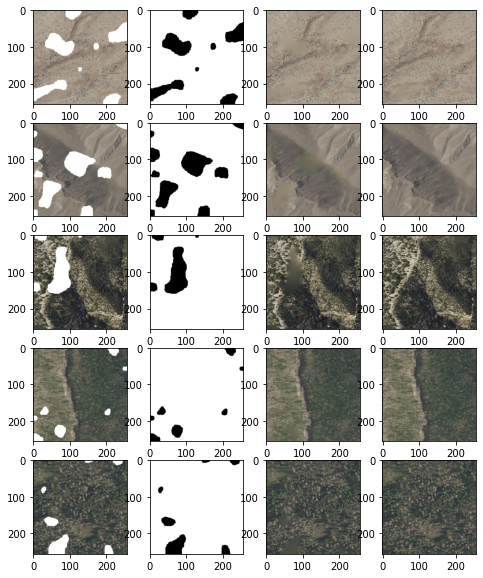

In [ ]:
rows = 5
sample_idx = 2
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(5):
    inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
    impainted_image = best_model.predict(inputs)
    axs[i][0].imshow(masked_images[i])
    axs[i][1].imshow(masks[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
    axs[i][3].imshow(sample_labels[i])

plt.show()

In [ ]:
run = wandb.init()
artifact = run.use_artifact('jedrzej_kopiszka/image-impainting_17_11_post_death_san/model-cerulean-sun-4:v16', type='model')
artifact_dir = artifact.download()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb:   4 of 4 files downloaded.  


In [ ]:
partial_conv_directory = './artifacts/model-cerulean-sun-4:v16'
partial_conv_best = keras.models.load_model(partial_conv_directory, custom_objects={"dice_coef":dice_coef})

In [ ]:
masked_image = masked_images[0].reshape((1,)+masked_images[0].shape)
mask = masks[0]

In [ ]:
norm_image = cv2.normalize(masked_image[0], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

norm_image = norm_image.astype(np.int8)

In [ ]:
norm_image.shape

(256, 256, 3)

In [ ]:
mask = cv2.bitwise_not(mask[:,:,0])

In [ ]:
mask= masks[0,:,:,0].astype(np.int8)

In [ ]:
cv2.inpaint(norm_image, mask, 3, cv2.INPAINT_TELEA)

error: ignored

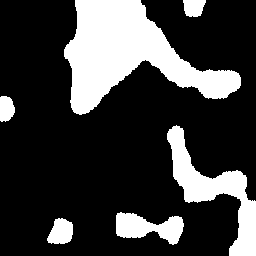

In [ ]:
indices_one = masks[0] == 1
indices_zero = masks[0] == 0
masks[0][indices_one] = 0 # replacing 1s with 0s
masks[0][indices_zero] = 1 # replacing 0s with 1sarray_to_img(masks[0])
array_to_img(masks[0])

In [ ]:
mask = masks[0][:,:,0]
mask = mask.astype('int8')

In [ ]:
masked_image = masked_images[0].reshape((1,)+masked_images[0].shape)[0].astype('float16')

In [ ]:
all_psnr = []
all_dice = []
all_mse = []
all_ssim = []
for batch in testgen:
    [masked_images, masks], sample_labels = batch
    for i in range(8):
      inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
      impainted_image = best_model.predict(inputs)
      a = impainted_image.reshape(impainted_image.shape[1:])
      b = sample_labels[i]
      all_psnr.append(tf.image.psnr(a,b,1.0).numpy())
      all_ssim.append(tf.image.ssim(tf.convert_to_tensor(a, tf.float32),tf.convert_to_tensor(b, tf.float32),1.0).numpy())
      all_dice.append(dice_coef(tf.cast(b, tf.double),tf.cast(a, tf.double)).numpy())
      all_mse.append(np.mean(tf.keras.metrics.mean_squared_error(b,a).numpy()))
      
    #break just one batch of test set for now

In [ ]:
print(np.mean(all_psnr), np.std(all_psnr))
print(np.mean(all_dice), np.std(all_dice))
print(np.mean(all_mse), np.std(all_mse))
print(np.mean(all_ssim), np.std(all_ssim))

32.632984 4.9031425
0.419894867779707 0.10345563647451868
0.0010166739 0.0013567441
0.92655075 0.063739054


In [ ]:
print(np.mean(all_psnr), np.std(all_psnr))
print(np.mean(all_dice), np.std(all_dice))
print(np.mean(all_mse), np.std(all_mse))
print(np.mean(all_ssim), np.std(all_ssim))

34.95908 4.541632
0.42054564464645183 0.10532729894525858
0.00052688713 0.00057690043
0.93651223 0.05236258


1/1 [==============================] - 0s 20ms/step


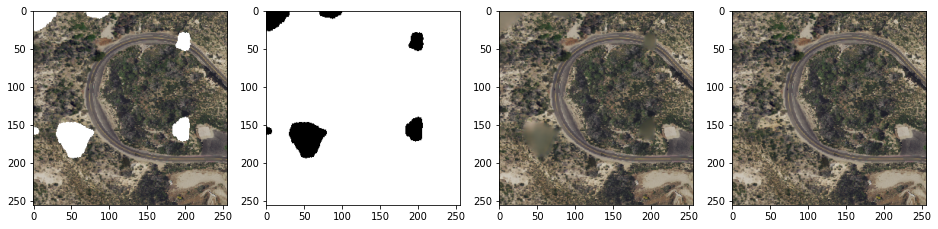

In [ ]:
rows = 1
sample_idx = 10
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(16, 4))
i=6
inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
impainted_image = best_model.predict(inputs)
axs[0].imshow(masked_images[i])
axs[1].imshow(masks[i])
axs[2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
axs[3].imshow(sample_labels[i])

In [ ]:
image_result = inpaint.inpaint_biharmonic(image_defect, mask, channel_axis=-1)

In [ ]:
[masked_images, masks], sample_labels = testgen[0]

In [ ]:
#Mask
indices_one = masks[4] == 1
indices_zero = masks[4] == 0
masks[4][indices_one] = 0 # replacing 1s with 0s
masks[4][indices_zero] = 1 # replacing 0s with 1sarray_to_img(masks[0])

In [ ]:
 image_result = inpaint.inpaint_biharmonic(masked_images[4], masks[4][:,:,0], multichannel=True)

In [ ]:
all_psnr = []
all_dice = []
all_mse = []
all_ssim = []
for batch in testgen:
    [masked_images, masks], sample_labels = batch
    for i in range(8):
      print(i)
      indices_one = masks[i] == 1
      indices_zero = masks[i] == 0
      masks[i][indices_one] = 0
      masks[i][indices_zero] = 1
      impainted_image = inpaint.inpaint_biharmonic(masked_images[i], masks[i][:,:,0], multichannel=True)
      a = impainted_image #.reshape(impainted_image.shape[1:])
      b = sample_labels[i]
      all_psnr.append(tf.image.psnr(a,b,1.0).numpy())
      all_ssim.append(tf.image.ssim(tf.convert_to_tensor(a, tf.float32),tf.convert_to_tensor(b, tf.float32),1.0).numpy())
      all_dice.append(dice_coef(tf.cast(b, tf.double),tf.cast(a, tf.double)).numpy())
      all_mse.append(np.mean(tf.keras.metrics.mean_squared_error(b,a).numpy()))
      
    #break just one batch of test set for now

In [ ]:
print(np.mean(all_psnr), np.std(all_psnr))
print(np.mean(all_dice), np.std(all_dice))
print(np.mean(all_mse), np.std(all_mse))
print(np.mean(all_ssim), np.std(all_ssim))

32.723614 4.613863
0.40891119852247293 0.08685515226450266
0.0008780013897979124 0.0008958154116788035
0.95088524 0.040085662


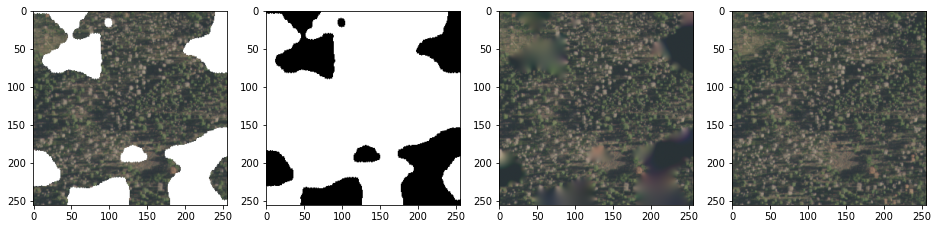

In [ ]:
rows = 1
sample_idx = 10
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(16, 4))
i=4
indices_one = masks[i] == 1
indices_zero = masks[i] == 0
masks[i][indices_one] = 0
masks[i][indices_zero] = 1
impainted_image = inpaint.inpaint_biharmonic(masked_images[i], masks[i][:,:,0], multichannel=True)
axs[0].imshow(masked_images[i])
indices_one = masks[i] == 0
indices_zero = masks[i] == 1
masks[i][indices_one] = 1
masks[i][indices_zero] = 0
axs[1].imshow(masks[i])
axs[2].imshow(impainted_image) #.reshape(impainted_image.shape[1:]))
axs[3].imshow(sample_labels[i])